# Exercise 1,  logistic regression
MNIST script credit: https://martin-thoma.com/classify-mnist-with-pybrain/

In [ ]:
%matplotlib inline
%pylab inline

In [ ]:
from struct import unpack
import gzip
from numpy import zeros, uint8, float32


def get_labeled_data(imagefile, labelfile):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    # Open the images with gzip in read binary mode
    images = gzip.open(imagefile, 'rb')
    labels = gzip.open(labelfile, 'rb')

    # Read the binary data

    # We have to get big endian unsigned int. So we need '>I'

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)  # skip the magic_number
    N = labels.read(4)
    N = unpack('>I', N)[0]

    if number_of_images != N:
        raise Exception('number of labels did not match the number of images')

    # Get the data
    x = zeros((N, rows, cols), dtype=float32)  # Initialize numpy array
    y = zeros((N, 1), dtype=uint8)  # Initialize numpy array
    for i in range(N):
        if i % 1000 == 0:
            print("i: %i" % i)
        for row in range(rows):
            for col in range(cols):
                tmp_pixel = images.read(1)  # Just a single byte
                tmp_pixel = unpack('>B', tmp_pixel)[0]
                x[i][row][col] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]
        data = {'x': x, 'y': y, 'rows': rows, 'cols': cols}
    return data #(x, y)

In [ ]:
from pylab import imshow, show, cm


def view_image(image, label=""):
    """View a single image."""
    print("Label: %s" % label)
    imshow(image, cmap=cm.gray)
    show()

In [4]:
print("Get testset")
testing = get_labeled_data('t10k-images-idx3-ubyte.gz',
                           't10k-labels-idx1-ubyte.gz')
print("Got {} testing datasets.".format(len(testing['x'])))
print("Get trainingset")
training = get_labeled_data('train-images-idx3-ubyte.gz',
                            'train-labels-idx1-ubyte.gz')
print("Got {} training datasets.".format(len(training['x'])))

Label: [2]


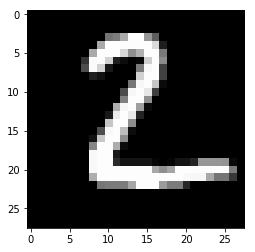

In [6]:
view_image(testing['x'][1], label=testing['y'][1])

Label: [3]


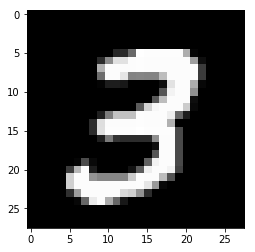

In [7]:
view_image(training['x'][7], label=training['y'][7])

In [8]:
training['x'][7].shape

(28, 28)

In [9]:
import numpy as np

In [10]:
def filter_0_1(data):
    """
    Keeps only the records corresponding to the labels 0 or 1.
    """
    mask = np.squeeze((data['y'] == 0) | (data['y'] == 1))
    # filtered data
    x = data['x'][mask]
    y = np.squeeze(data['y'][mask])
    # unraveling
    flat_x = x.reshape(x.shape[0], -1)
    means = flat_x.mean(axis=1)
    stds = flat_x.std()
    flat_x = (flat_x.transpose() - means).transpose() / stds
    print(means.shape)
    # flat_x = np.array([np.ravel(x[i]) 
    #                    for i in range(x.shape[0])])
    # Adding column of ones
    flat_x = np.c_[flat_x, np.ones(flat_x.shape[0])]
    filtered_data = {'x': flat_x.transpose(),
                     'y': y,
                     'rows': data['rows'],
                     'cols': data['cols']}
    return filtered_data

training_0_1 = filter_0_1(training)
testing_0_1 = filter_0_1(testing)

(12665,)
(2115,)


In [11]:
print(training_0_1['x'].shape, training_0_1['y'].shape)
print(testing_0_1['x'].shape, testing_0_1['y'].shape)

(785, 12665) (12665,)
(785, 2115) (2115,)


In [12]:
def sigmoid_array(x):
    x = np.clip( x, -500, 500 )
    return 1 / (1 + np.exp(-x))

In [47]:
def logistic_regression(theta, data, target):
    '''
    Receives the training data X,
    the training target values (house prices) y, and the current parameters θ.
    Returns the loss function.
    '''
    h_prime = sigmoid_array(np.squeeze(np.dot(theta.transpose(), data)))
    res = -(np.dot(target, np.log(h_prime)) + np.dot(1-target, np.log(1-h_prime)))
    res = res.clip(max=np.finfo(res.dtype).max)
    return res

def logistic_regression_prime(theta, data, target):
    '''
    Receives the training data X,
    the training target values (house prices) y, and the current parameters θ.
    Returns the jacobian of the loss function.
    '''
    h_prime = sigmoid_array(np.squeeze(np.dot(theta.transpose(), data)))
    res = np.dot(data, (h_prime - target))
    res = res.clip(min=np.finfo(res.dtype).min, max=np.finfo(res.dtype).max)
    return res

def logistic_regression_second(theta, data, target):
    '''
    Receives the training data X,
    the training target values (house prices) y, and the current parameters θ.
    Returns the hessian of the loss function.
    '''
    h_prime = sigmoid_array(np.squeeze(np.dot(theta.transpose(), data)))
    res =  np.dot(data, data.transpose()) * np.dot(h_prime, (1 - h_prime))
    res = res.clip(min=np.finfo(res.dtype).min, max=np.finfo(res.dtype).max)
    return res

In [48]:


from scipy import optimize
def run_optimization(to_minimize,jacobian,hessian, x_train, y_train):
    starting_guess = (2 * np.random.rand(x_train.shape[0], 1) -1 )/100
    results  =  optimize.minimize(to_minimize,
                                  starting_guess,
                                  jac = jacobian,
                                  hess = hessian,
                                  method='Newton-CG',
                                  #method = 'Powell',
                                  #method = 'Nelder-Mead',
                                  # tol = 0.00000005,
                                  args=(x_train, y_train),
                                  options = {#'maxiter': 1000000,
                                             'disp': True}
                                 )
    return (results.success, results.x)

In [ ]:
results = run_optimization(logistic_regression,
                           logistic_regression_prime,
                           logistic_regression_second,
                           training_0_1['x'], training_0_1['y'])


In [ ]:
results

In [ ]:
true_theta = results[1]

In [ ]:
def func_eval(theta, x):
    return sigmoid_array(np.squeeze(np.dot(theta.transpose(), x)))

In [ ]:
y_train_eval = func_eval(true_theta, training_0_1['x'])
y_test_eval = func_eval(true_theta, testing_0_1['x'])

In [ ]:
y_train_eval[:5]>0.5

In [ ]:
training_0_1['y'][:5]

In [ ]:
import pandas as pd
training_comparison = pd.DataFrame({'true':training_0_1['y'], 'estimated':(y_train_eval>0.5) })

In [ ]:
training_comparison[training_comparison['true'] == training_comparison['estimated']].shape

In [ ]:
training_comparison[training_comparison['true'] != training_comparison['estimated']].shape

In [ ]:
testing_comparison = pd.DataFrame({'true':testing_0_1['y'], 'estimated':(y_test_eval>0.5) })

In [ ]:
testing_comparison[testing_comparison['true'] != testing_comparison['estimated']].shape

In [ ]:
testing_comparison[testing_comparison['true'] == testing_comparison['estimated']].shape

In [ ]:
1 - 2/(6+2109)